# Installs

In [ ]:
#Instalador de las librerias necesarias
#
#!pip install owlready2 agentpy seaborn numpy
#

In [ ]:
# Model design
from owlready2 import *
import agentpy as ap
import numpy as np

# Visualization
import seaborn as sns

#Pathfinding
import math
import heapq

#Misc
from matplotlib import pyplot as plt
import IPython
import random

#Assistance Functions (Pathfinding, Grid Sizes, Etc.)

In [ ]:
def heuristic(a,b):
  #Distancia de Manhattan, resta el valor absoluto de la XY axtual con la XY destino
  # a[0] = x inicial
  # b[0] = x final
  # a[1] = y inicial
  # b[1] = y final
  return abs(a[0] - b[0]) + abs(a[1] - b[1])

def get_neighbors(grid,node):
  neighbors = []

  x,y = node

  if x > 0:
    neighbors.append((x-1,y))

  if x < grid.shape[1] - 1:
    neighbors.append((x+1,y))

  if y > 0:
    neighbors.append((x,y-1))

  if y < grid.shape[0] -1:
    neighbors.append((x,y+1))

  return neighbors

# Ontology

Correr la ontologia **SOLO UNA VEZ** ,si da problemas usar el comando de borrar y volver a crearla

In [ ]:
"""
#Creamos la ontologia
onto = get_ontology("file://ontologia.owl")


with onto:
  class Entity(Thing):
    pass

  class Camera(Entity):
    pass

  class Drone(Entity):
    pass

  class Intruder(Entity):
    pass

  class Box(Entity):
    pass

  class Place(Thing):
    pass

  class is_in_place(ObjectProperty):
      domain = [Entity]
      range = [Place]

  class at_position(DataProperty,FunctionalProperty):
        domain = [Place]
        range = [str]

  class is_following_intruder(ObjectProperty):
    domain = [Drone]
    range = [Intruder]

  class is_called_by_camera(ObjectProperty):
    domain = [Drone]
    range = [Camera]
"""

'\n#Creamos la ontologia\nonto = get_ontology("file://ontologia.owl")\n\n\nwith onto:\n  class Entity(Thing):\n    pass\n\n  class Camera(Entity):\n    pass\n\n  class Drone(Entity):\n    pass\n\n  class Intruder(Entity):\n    pass\n\n  class Box(Entity):\n    pass\n\n  class Place(Thing):\n    pass\n\n  class is_in_place(ObjectProperty):\n      domain = [Entity]\n      range = [Place]\n\n  class at_position(DataProperty,FunctionalProperty):\n        domain = [Place]\n        range = [str]\n\n  class is_following_intruder(ObjectProperty):\n    domain = [Drone]\n    range = [Intruder]\n\n  class is_called_by_camera(ObjectProperty):\n    domain = [Drone]\n    range = [Camera]\n'

In [ ]:
#Delete just in case
#onto.destroy(update_relation = True, update_is_a = True)

#Camera Agent

In [ ]:
class CameraAgent(ap.Agent):

  """
    <-- Funciones de Ejecucion -->
  """

  """
    Funcion de Setup
  """

  def setup(self):
    self.agentType = 0
    self.neighbors = []

    self.actions = {

    }

    self.rules = {

    }


  """
    Funcion de See
  """
  def see(self, e):
    self.neighbors = e.neighbors(self,2)

  """
    Funcion de Next
  """
  def next(self):
    for act in self.actions:
      for rule in self.rules:
        if rule(act):
          act()

  """
    Funcion de Paso
  """

  def step(self):
    self.see(self.model.grid)
    self.next()

    for neighbor in self.neighbors:
      print(self.model.grid.positions[neighbor])

  """
    Funcion de Update
  """

  def update(self):
    pass

  """
    Funcion de End
  """

  def end(self):
    pass

  """
    <-- Acciones -->
  """

  """
    <-- Reglas -->
  """

#Drone Agent

In [ ]:
class DroneAgent(ap.Agent):

  """
    <-- Funciones de Ejecucion -->
  """

  """
    Funcion de Setup
  """

  def setup(self):
    self.agentType = 1

    #Variables de patrulla
    self.path = []
    self.path_counter = 0

    grid_length_min = round(self.model.p.M * 0.3 - 1)
    grid_length_max = round(self.model.p.M - (grid_length_min + 1))

    grid_width_min = round(self.model.p.N * 0.3 - 1)
    grid_width_max = round(self.model.p.N - (grid_width_min + 1 ))


    #self.path = [(grid_length_min,grid_width_min), (grid_length_max,grid_length_min), (grid_length_max,grid_width_max),(grid_length_min, grid_width_max) ]

    """
    for i in range(grid_length_min,grid_length_max):
      for j in range(grid_width_min,grid_width_max):
        self.path.append((i,j))
        if reverse:
          self.path_side.reverse()
          reverse = !reverse
        self.path.append(self.path_side)
    """

    for i in range(grid_length_min,grid_length_max):
      self.path.append((i,grid_width_min))

    for i in range(grid_width_min,grid_width_max):
      self.path.append((grid_length_max,i))

    for i in range(grid_length_max,grid_length_min,-1):
      self.path.append((i,grid_width_max))

    for i in range(grid_width_max,grid_width_min,-1):
      self.path.append((grid_length_min,i))

    self.actions = (
      self.patrol,
    )

    self.rules = (
      self.patrol_rule,
    )


  """
    Funcion de See
  """
  def see(self, e):
    pass

  """
    Funcion de Next
  """
  def next(self):
    for act in self.actions:
      for rule in self.rules:
        if rule(act):
          act()

  """
    Funcion de Paso
  """

  def step(self):
    self.see(self.model.grid)
    self.next()

  """
    Funcion de Update
  """

  def update(self):
    pass

  """
    Funcion de End
  """

  def end(self):
    pass

  """
    <-- Acciones -->
  """
  def patrol(self):
    print("PATRULLAMOS")
    if(self.path_counter >= len(self.path)):
      self.path_counter = 0
    self.model.grid.move_to(self,self.path[self.path_counter])
    self.path_counter += 1


  """
    <-- Reglas -->
  """
  def patrol_rule(self, act):
    validator = [False]

    if act == self.patrol:
      validator[0] = True

    return sum(validator) == 1

#Intruder Agent

In [ ]:
class IntruderAgent(ap.Agent):

  """
    <-- Funciones de Ejecucion -->
  """

  """
    Funcion de Setup
  """

  def setup(self):
    self.agentType = 2

    self.actions = {

    }

    self.rules = {

    }


  """
    Funcion de See
  """
  def see(self, e):
    pass

  """
    Funcion de Next
  """
  def next(self):
    for act in self.actions:
      for rule in self.rules:
        if rule(act):
          act()

  """
    Funcion de Paso
  """

  def step(self):
    self.see(self.model.grid)
    self.next()

  """
    Funcion de Update
  """

  def update(self):
    pass

  """
    Funcion de End
  """

  def end(self):
    pass

  """
    <-- Acciones -->
  """

  """
    <-- Reglas -->
  """

#DroneModel

In [ ]:
class DroneModel(ap.Model):

  """
    <-- Funcion de Inicializacion -->
  """
  def setup(self):
    self.steps = 0
    self.cameras = ap.AgentList(self,self.p.cameras,CameraAgent)
    self.drones = ap.AgentList(self,self.p.drones,DroneAgent)
    self.intruders = ap.AgentList(self,self.p.intruders,IntruderAgent)

    #Instancia Grid
    self.grid = ap.Grid(self, (self.p.M, self.p.N), track_empty=True)
    self.reservations = ap.Grid(self, (self.p.M, self.p.N), track_empty=True)

    #Asignacion de Agentes
    self.grid.add_agents(self.drones, [(round(self.model.p.M - (self.model.p.M * 0.7)) - 1,  round(self.model.p.N - (self.model.p.N * 0.7))-1)], empty=True)

    """
    for i in range(self.p.cameras):
      for j in range(0,self.p.M,):
        for k in range(0,self.p.N):
          self.grid.add_agents(self.cameras, [(j,k)], empty=True)
    """

    self.grid.add_agents(self.cameras, random=True, empty=True)
    self.grid.add_agents(self.intruders, random=True, empty=True)


  def step(self):
    print(f"Step: {self.steps}")
    self.cameras.step()
    self.drones.step()
    self.intruders.step()

    #Informacion de la sumulacion
    self.steps += 1

  def next(self):
    pass

  def update(self):
    pass

  def end(self):
    pass

#Paremeters

In [ ]:
parameters = {
    'M': 10,
    'N': 10,
    'cameras': 5,
    'drones': 1,
    'intruders': 1,
    'steps': 10,
}

#Animation

In [ ]:
def animation_plot(model, ax):
    """
    Función de animación
    @param model: modelo
    @param ax: axes (matplotlib)
    """
    # Definición de atributo para tipo de agente
    agent_type_grid = model.grid.attr_grid('agentType')
    # Definición de gráfico con colores (de acuerdo al tipo de agente)
    ap.gridplot(agent_type_grid, cmap='Accent', ax=ax)
    # Definición de título del gráfico
    ax.set_title(f"Drone Model \n Time-step: {model.t}, "
                 f"Blanmk: {0}")

#Simulation

AgentpyError: Cannot add more agents than empty positions.

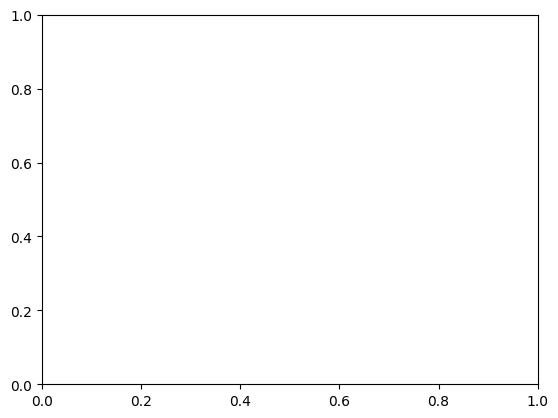

In [ ]:
#SIMULATION:

#Create figure (from matplotlib)
fig, ax = plt.subplots()

#Create model
model = DroneModel(parameters)


#Run with animation
#If you want to run it without animation then use instead:
#model.run()
animation = ap.animate(model, fig, ax, animation_plot)
#This step may take a while before you can see anything

#Print the final animation
IPython.display.HTML(animation.to_jshtml())